# Spatial spectra

Make wave-number spectra of various runs (based on Andrew's script https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/spectra/spectra.ipynb)

In [1]:
# import pyfftw # faster but not available - get this installed?
import numpy as np
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import copy
from scipy.fftpack import fft2, fftn, fftshift
import scipy.signal.windows as ssw
from scipy import interpolate
# import matplotlib.colors as colors
# import xarray as xr
# import netCDF4 as nc
# from tqdm import tqdm_notebook
# from mpl_toolkits.basemap import Basemap
# from calendar import month_abbr
import cmocean as cm

from collections import OrderedDict

import sys, os
from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:35325 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 33.67 GB


In [3]:
figdir = 'spectra_figs/'
def savefigure(fname):
#    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=50, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=100, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
# Load session and define experiments
session = cc.database.create_session('/g/data/e14/rmh561/access-om2/archive/databases/cc_database_nummix.db')
exptdict = OrderedDict([
    ('01degRYF',   {'model':'ACCESS-OM2-01', 'expt':'01deg_jra55_ryf',
                 'usnap':'snapshot', 'tsnap':'snap',
                'n_files':-4, 'itime': None,'ftime':None}),
    ('01degRYFhv',   {'model':'ACCESS-OM2-01-hvisc', 'expt':'01deg_jra55v13_ryf9091_k_smag_iso3',
                 'usnap':'snapshot', 'tsnap':'snap',
                'n_files':-4, 'itime': None,'ftime':None}),
    ('025degRYF',   {'model':'ACCESS-OM2-025-RG', 'expt':'025deg_jra55_ryf_rediGM',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
    ('025degRYFnorediGM',   {'model':'ACCESS-OM2-025', 'expt':'025deg_jra55_ryf_norediGM',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
    ('025degRYFnoGM',   {'model':'ACCESS-OM2-025-R', 'expt':'025deg_jra55_ryf_noGM',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
    # ('025degRYF75',   {'model':'ACCESS-OM2-025-KDS75', 'expt':'025deg_jra55_ryf_kds75',
    #              'usnap':'snapshot', 'tsnap':'snapshot',
    #             'n_files':-1, 'itime': None,'ftime':None}),
    ('1degRYF',   {'model':'ACCESS-OM2-1-KDS50', 'expt':'1deg_jra55_ryf_kds50',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
])

In [5]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
#    'Gulf-Stream':              [ -68,  -40,  30,  44],
#    'Kuroshio':                 [-215, -180,  30,  45],
    'Eastern-Tropical-Pacific': [-150, -100, -10,  10],
#    'Southern-Ocean-Australia': [-250, -200, -60, -45],
    'Southern-Ocean-Pacific':   [-180, -100, -65, -45],
#    'Agulhas':                  [  10,   80, -55, -35]
}
# Rough estimate of Deformation radius wavenumber (degree^-1, Chelton 1998)
Re = 6371.0
fac = 4.*np.pi**2*Re/360./2
kd = {'Gulf-Stream': fac/(30.)*(np.cos((35.)*np.pi/180.)+1.),
      'Kuroshio': fac/(35.)*(np.cos((32.5)*np.pi/180.)+1.),
      'Eastern-Tropical-Pacific': fac/(230.)*(np.cos((0.)*np.pi/180.)+1.),
      'Southern-Ocean-Australia': fac/(15.)*(np.cos((52.5)*np.pi/180.)+1.), # Marine's region
      'Southern-Ocean-Pacific': fac/(15.)*(np.cos((52.5)*np.pi/180.)+1.),
      'Agulhas': fac/(25.)*(np.cos((42.5)*np.pi/180.)+1.)
      }

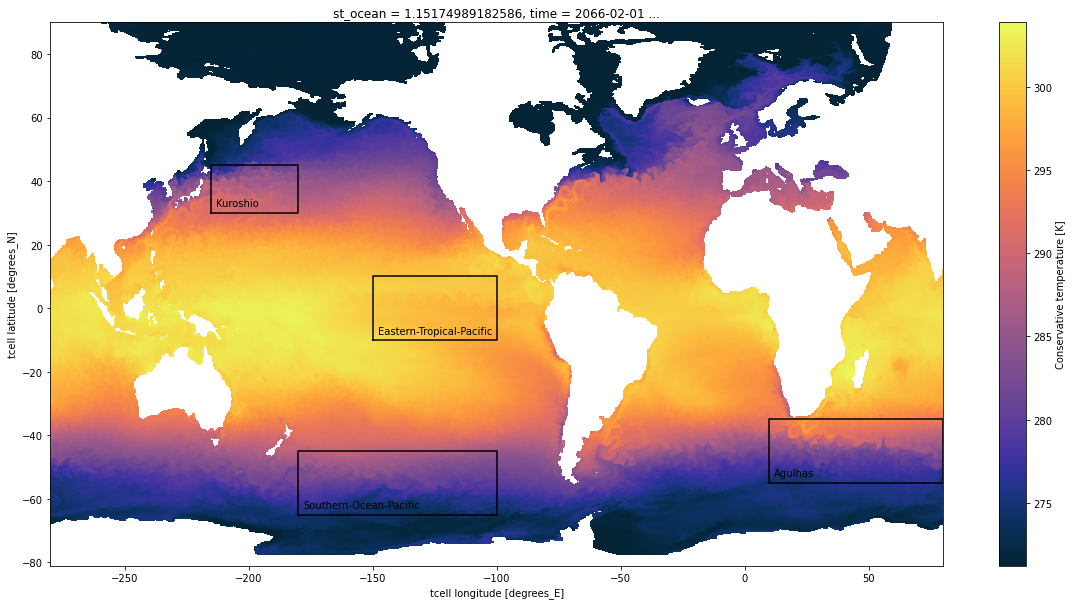

In [15]:
# Plot regions over SSH-variance plot (use 1/10th for prod figure on Gadi - memory limits)
fig = plt.figure(figsize=(20,10),facecolor='w')

#eta_t = cc.querying.getvar('01deg_jra55_ryf', 'eta_t', session, ncfile='ocean_daily.nc')
eta_t = cc.querying.getvar('025deg_jra55_ryf_norediGM', 'temp', session, ncfile='ocean_snapshot.nc')
eta_t.isel(time=0).isel(st_ocean=0).plot(cmap=cm.cm.thermal)
# SSHvar = (eta_t**2.).mean('time')-(eta_t.mean('time'))**2. # Use on Gadi - memory blown
# SSHvar.plot()

for locname,loc in locations.items():
    plt.plot([loc[0], loc[1], loc[1], loc[0], loc[0]],[loc[2], loc[2], loc[3], loc[3], loc[2]],'-k')
    plt.text(loc[0]+2,loc[2]+2,locname)
savefigure('Regions')

In [6]:
# load model snapshots and grid data
data = copy.deepcopy(exptdict)  # this will store KE and temp fields under the same keys as exptdata.exptdict
for ekey in data.keys():
        expt = data[ekey]['expt']
        n_files = data[ekey]['n_files']
        usnap = 'ocean_' + data[ekey]['usnap'] + '.nc'
        tsnap = 'ocean_' + data[ekey]['tsnap'] + '.nc'
        
        try:
            data[ekey]['u'] = cc.querying.getvar(expt, 'u',session,n=n_files, ncfile=usnap).isel(st_ocean=0).fillna(0.0)
            data[ekey]['v'] = cc.querying.getvar(expt, 'v',session,n=n_files, ncfile=usnap).isel(st_ocean=0).fillna(0.0)

            sz = np.shape(data[ekey]['u'])
            print('Found ' + str(sz[0]) + ' snapshots of velocity for ' + data[ekey]['model'])
            
        except:
            print('Velocity snapshots not found ' + data[ekey]['model'])
        
        # Load SST and temperature at depth
        try:
            tmp = cc.querying.getvar(expt, 'temp',session,n=n_files, ncfile=tsnap)
            
            data[ekey]['SST'] = tmp.isel(st_ocean=0)-273.15
            data[ekey]['T100'] = tmp.sel(st_ocean=100.,method='nearest')-273.15
            
            # T10 = tmp.sel(st_ocean=10.,method='nearest')-273.15                  
            # data[ekey]['T10'] = T10.fillna(0.0)
            # T200 = tmp.sel(st_ocean=200.,method='nearest')-273.15                  
            # data[ekey]['T200'] = T200.fillna(0.0)
            # T300 = tmp.sel(st_ocean=300.,method='nearest')-273.15                  
            # data[ekey]['T300'] = T300.fillna(0.0)
            # T500 = tmp.sel(st_ocean=500.,method='nearest')-273.15                  
            # data[ekey]['T500'] = T500.fillna(0.0)
            
            sz = np.shape(data[ekey]['SST'])
            print('Found ' + str(sz[0]) + ' snapshots of temperature for ' + data[ekey]['model'])

        except:
            print('Temperature snapshots not found ' + data[ekey]['model'])

Found 12 snapshots of velocity for ACCESS-OM2-01
Found 4 snapshots of temperature for ACCESS-OM2-01


Found 12 snapshots of velocity for ACCESS-OM2-01-hvisc


Found 4 snapshots of temperature for ACCESS-OM2-01-hvisc


Found 24 snapshots of velocity for ACCESS-OM2-025-RG
Found 24 snapshots of temperature for ACCESS-OM2-025-RG


Found 24 snapshots of velocity for ACCESS-OM2-025
Found 24 snapshots of temperature for ACCESS-OM2-025


Found 24 snapshots of velocity for ACCESS-OM2-025-R
Found 24 snapshots of temperature for ACCESS-OM2-025-R


Found 120 snapshots of velocity for ACCESS-OM2-1-KDS50
Found 120 snapshots of temperature for ACCESS-OM2-1-KDS50


In [7]:
# Cut down 1-degree data to 12 to speed up uniform-grid stuff:
data['1degRYF']['SST'] = data['1degRYF']['SST'].isel(time=slice(0,12))
data['1degRYF']['T100'] = data['1degRYF']['T100'].isel(time=slice(0,12))
data['1degRYF']['u'] = data['1degRYF']['u'].isel(time=slice(0,12))
data['1degRYF']['v'] = data['1degRYF']['v'].isel(time=slice(0,12))

In [8]:
def detrend(f,dim):
    """
    Detrend multidimensional dataarray f in dimension dim.
    In all other dimensions, remove linear function from first to last element in dimension given by string dim.
    Follows method of Errico1985a sec 2a http://dx.doi.org/10.1175/1520-0493(1985)113<1554:SCFALA>2.0.CO;2
    WARNING: can produce a plaid pattern that produces artifacts in fft. Better to use window instead.
    
    cf. ArbicPolzinScottRichmanShriver2013a - they detrend with a 2d least-squares fit (this won't ensure periodicity but doesn't introduce spurious patterns)
    """
    # I don't like using eval but I can't think of a better way right now...
    first = eval('f.isel('+dim+'=0)')
    last = eval('f.isel('+dim+'=-1)')
    n = f[dim].size
    slope = (last-first)/(n-1)
    scale = xr.DataArray(np.arange((1-n)/2,(n+1)/2), coords={dim: f[dim]}, dims=[dim])
    return f-scale*slope # subtract outer product    

In [9]:
# Intepolation to uniform grid
def interp_to_uniform(var,dsfac=1.):
    """
    Interpolate variable from lon, lat onto a grid in meters with uniform grid-spacing.
    NOTE: This will not work in the tripolar area
    var = input variable
    xvar = 'xt_ocean' or 'xu_ocean'
    yvar = 'yt_ocean' or 'yu_ocean'
    dsfac = fraction of minimum grid spacing to take as uniform grid spacing.
    """
    tdim, ydim, xdim = var.dims  # abstract out dimension names - NB: assumes this order of dimensions
    lon = var[xdim]
    lat = var[ydim]
    LON, LAT = np.meshgrid(lon, lat, indexing='ij')

    # Construct meter grid on input:
    lon_cen = np.mean([np.max(lon),np.min(lon)])
    lat_cen = np.mean([np.max(lat),np.min(lat)])

    Re = 6371000.0
    Y = np.pi*Re/180.*(LAT-lat_cen)
    X = np.pi*Re/180.*(LON-lon_cen)*np.cos(np.pi*LAT/180.)

    # Construct uniform meter grid:
    xmin, xmax = np.max(X[0,:]), np.min(X[-1,:])
    ymin, ymax = Y[0,0], Y[0,-1]
    Lx, Ly = xmax-xmin, ymax-ymin

    ds = dsfac*np.min([np.min(np.min(X[1:,:]-X[:-1,:])), Y[0,1]-Y[0,0]])

    xu, yu = np.arange(xmin+ds/2,xmax,ds), np.arange(ymin+ds/2,ymax,ds)
    nx, ny = len(xu), len(yu)
    XU, YU = np.meshgrid(xu, yu, indexing='ij')

    # Do interpolation
    # The easy way - revert to lon, lat for interpolation using RectBivariateSpline (regular input grid):
    LATU = YU*180./np.pi/Re+lat_cen
    LONU = XU*180./np.pi/Re/np.cos(np.pi*LATU/180.)+lon_cen

    tL = np.shape(var.values)[0]
    varout = np.zeros((tL, ny, nx))
    for ti in range(tL):
        if (ti % 5 == 0):
            print('Uniform-grid interpolation %03d of %03d' % (ti,tL))
        varin = var.values[ti,:,:].T
        f = interpolate.RectBivariateSpline(lon,lat, varin)
        varout[ti,:,:] = f.ev(LONU.T,LATU.T)

    # Note: It might be better, but slower, to do the interpolation in x,y and use griddata (irregular input grid)

    # put into a DataArray:
    varout = xr.DataArray(varout, dims=['time','y', 'x'], coords={'time': var.time, 'y': yu, 'x': xu})

    return(varout)

In [10]:
# Testing code
# loc = locations['Kuroshio']
# var = data['025degRYF']['u'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))

# varout = interp_to_uniform(var)

# fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,16),facecolor='w')

# varaxes[0][0].pcolormesh(LON,LAT,varin,cmap='RdBu_r',vmin=-0.5,vmax=0.5)
# axes[0][0].set_title('Input on input lon,lat grid')
# # axes[0][0].plot(LON[:],LAT[:],'.k')
# # axes[0][0].plot(LONU[:],LATU[:], '.b')

# axes[0][1].pcolormesh(X,Y,varin,cmap='RdBu_r',vmin=-0.5,vmax=0.5)
# axes[0][1].set_title('Input on input x,y grid')
# # axes[0][1].plot(X[:],Y[:],'.k')
# # axes[0][1].plot(XU[:],YU[:], '.b')

# axes[1][0].pcolormesh(LONU,LATU,out,cmap='RdBu_r',vmin=-0.5,vmax=0.5)
# axes[1][0].set_title('Output on output lon,lat grid')
# # axes[1][0].plot(LON[:],LAT[:],'.k')
# # axes[1][0].plot(LONU[:],LATU[:], '.b')

# axes[1][1].pcolormesh(XU,YU,out,cmap='RdBu_r',vmin=-0.5,vmax=0.5)
# axes[1][1].set_title('Output on output x,y grid')
# # axes[1][1].plot(X[:],Y[:],'.k')
# # axes[1][1].plot(XU[:],YU[:], '.b')


In [11]:
def window(f,dim,window='hamming'):
    """
    Apply window to multidimensional dataarray f in dimension dim.
    
    cf. ArbicPolzinScottRichmanShriver2013a http://dx.doi.org/10.1175/JPO-D-11-0240.1
    - they detrend with a 2d least-squares fit before windowing (and use a different window function)
    ScottWang2005a do something similar
    TullochMarshallHillSmith2011a use flipping instead to ensure periodicity
    """
    return f*xr.DataArray(ssw.get_window(window, f[dim].size), coords={dim: f[dim]}, dims=[dim])

In [12]:
def azimuthal_sum(v2dtfft):  # following DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1
# NB: omits zero wavenumber
    dkh = np.max([np.max(np.diff(v2dtfft.ki)), np.max(np.diff(v2dtfft.kj))])
    dkmin = np.min([np.min(np.diff(v2dtfft.ki)), np.min(np.diff(v2dtfft.kj))])
    Nmax = int(np.ceil(np.sqrt(2)*max(v2dtfft.shape)/2))  # NB: extends sqrt(2) times further to get into corners
    kp = dkh*range(1,Nmax+1)
    C = 0.0*kp  # number of wavenumber points in each annulus (C in DurranWeynMenchaca2017a)
    v2dtfftradial = 0.0*kp
    radius = np.sqrt(v2dtfft.ki**2+v2dtfft.kj**2)
    ones = 1 + 0*v2dtfft
    
    # sum in each annulus
    for i,k in enumerate(kp):
        v2dtfftradial[i] = v2dtfft.where(radius>=k-dkh/2).where(radius<k+dkh/2).sum()
        C[i] = ones.where(radius>k-dkh/2).where(radius<=k+dkh/2).sum()

    v2dtfftradial *= dkmin  # scale as in eq (24) (assuming scaling in eq (22) is already done)

# eq (26): compensate for number of (k,l) pairs in each annulus
# NB: Parseval's theorem no longer exactly holds (p 3905)
    C = np.where(C==0, 1, C)  # ensures no division by zero (v2dtfftradial=0 there anyway)
    v2dtfftradial *= 2.0*np.pi*kp/C/dkmin

    v2dtfftradial = xr.DataArray(v2dtfftradial, dims=['k'], coords={'k': kp})
    v2dtfftradial.k.attrs['units'] = v2dtfft.ki.attrs['units']
    v2dtfftradial.k.attrs['long_name'] = 'wavenumber magnitude'

# Truncate spectrum at Nyquist frequency (high k's in corners are anisotropically sampled):
# NB: Also breaks Parseval's theorem
    kminmax = np.min([np.max(v2dtfft.ki), np.max(v2dtfft.kj)])
    v2dtfftradial = v2dtfftradial.sel(k=slice(0.,kminmax))    

    return v2dtfftradial

In [13]:
def fft_KE(u,v=False,detrnd=False, iuni=False, k_grid_units=True):
    """
    0.5 * FFT squared magnitude (time-mean spectrum, in grid space).
    Coords are assumed to be t, y, x (in that order).
    """

    if (v is None):
        have_v = False
    else:
        have_v = True
        
    if (iuni):
        u = interp_to_uniform(u)
        if (have_v):
            v = interp_to_uniform(v)

    tdim, ydim, xdim = u.dims  # abstract out dimension names - NB: assumes this order of dimensions
    nx = u[xdim].size
    ny = u[ydim].size
    dx = np.max(np.diff(u[xdim]))
    dy = np.max(np.diff(u[ydim]))

# detrend data
# Note: detrend does not seem to make much difference.
    if (detrnd):
        udt = detrend(detrend(u,xdim),ydim)  # don't use on its own - produces artifacts 
        if (have_v):
            vdt = detrend(detrend(v,xdim),ydim)  # don't use on its own - produces artifacts

# Window data and subtract mean
    udt = window(window(u,xdim),ydim)
    udt -= udt.mean(xdim, skipna=True).mean(ydim, skipna=True)

    if (have_v):
        vdt = window(window(v,xdim),ydim)
        vdt -= vdt.mean(xdim, skipna=True).mean(ydim, skipna=True)    

# FFTs:
    udtfft = fftn(udt.values, axes=(1,2))  # fft amplitude at each time
    if (have_v):
        vdtfft = fftn(vdt.values, axes=(1,2))

    KEdtfft = (udtfft*udtfft.conjugate()).real  # squared magnitude
    if (have_v):
        KEdtfft += (vdtfft*vdtfft.conjugate()).real

    KEdtfft = KEdtfft.mean(axis=0)  # time-mean
    KEdtfft[0,0] = np.nan  # nan at removed zero frequency
    KEdtfft = fftshift(KEdtfft)  # put zero wavenumber in array centre

    KEdtfft *= dx*dy/2. # Scaling to satisfy Parsevals theorem in grid coordinates
                     # so that sum(sum(KEdtfft*dkx*dky)) = sum(sum(((u**2+v**2)/2.)*dx*dy))
                     # where kx and ky are in cycles / x-grid cell and cycles / y-grid-cell
                     # (see below for rescaling if kx and ky are in radians/grid units)
    
    #  KEdtfft *= dx*dy/(8.0*(np.pi)**2*nx*ny)  # scaling as per eq (22) of DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1

    if (k_grid_units):
        # k in units cycles/dx:
        KEdtfft = xr.DataArray(KEdtfft, dims=['kj','ki'], 
                                coords={'kj': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny), 
                                       'ki': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)},
                                attrs={'long_name': 'wavenumber spectrum in grid units'})
        KEdtfft.ki.attrs['units'] = 'cycles/dx'
        KEdtfft.kj.attrs['units'] = 'cycles/dy'
        KEdtfft.ki.attrs['long_name'] = 'x wavenumber'
        KEdtfft.kj.attrs['long_name'] = 'y wavenumber'

        # No rescaling

    else:
        # k in units rads/(units of dx)
        KEdtfft = xr.DataArray(KEdtfft, dims=['kj','ki'], 
                            coords={'kj': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny)*(2*np.pi/dy), 
                                    'ki': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)*(2*np.pi/dx)},
                               attrs={'long_name': 'wavenumber spectrum in grid units'})
        KEdtfft.ki.attrs['units'] = 'radians/degree'
        KEdtfft.kj.attrs['units'] = 'radians/degree'
        KEdtfft.ki.attrs['long_name'] = 'x wavenumber'
        KEdtfft.kj.attrs['long_name'] = 'y wavenumber'

        # Rescale to satisfy Parseval's theorem:
        KEdtfft /= 4*np.pi**2./dx/dy

    return KEdtfft

Uniform-grid interpolation 000 of 001


Uniform-grid interpolation 000 of 001


2D fft sum = 1.45e+12
Radial fft sum = 1.45e+12
Uniform-grid interpolation 000 of 001
Uniform-grid interpolation 000 of 001
Spatial sum = 1.45e+12


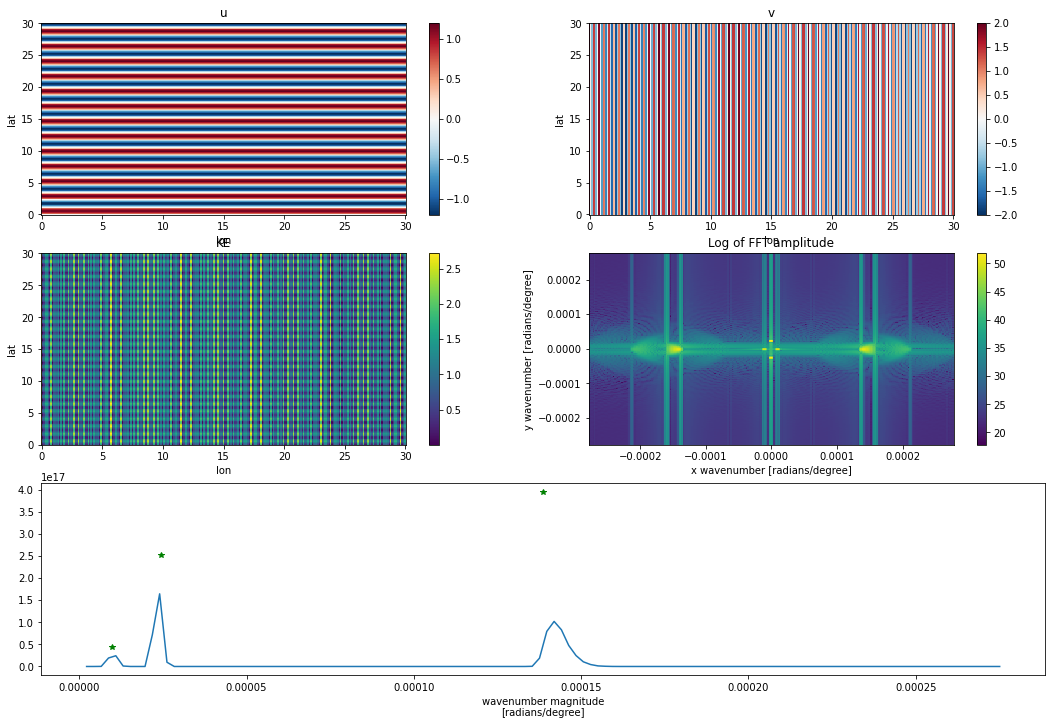

In [14]:
# Testing with dummy data on a longitude/latitude grid:

# LON/LAT:
nlon, nlat = 256, 256
lon, lat = np.linspace(0.,30.,nlon),np.linspace(0.,30.,nlat)
dlon, dlat = np.max(np.diff(lon)),np.max(np.diff(lat))
LON, LAT = np.meshgrid(lon,lat)
t = [0]

# X/Y (for parsevals check):
Re = 6371000.0
Y = np.pi*Re/180.*(LAT-np.mean(lat))
X = np.pi*Re/180.*(LON-np.mean(lon))*np.cos(np.pi*LAT/180.)
DY = np.pi*Re/180.*dlat*np.ones_like(Y)
DX = np.pi*Re/180.*dlon*np.cos(np.pi*LAT/180.)

# dummy solution
k1, k2, k3 = 2.*np.pi/(20.*dlat), 2.*np.pi/(50.*dlon), 2.*np.pi/(3.5*dlon)
a1, a2, a3 = 1.2, 0.5, 1.5
u, v = np.zeros((1,nlat,nlon)), np.zeros((1,nlat,nlon))
u[0,:,:] = a1*np.sin(k1*LAT)
v[0,:,:] = a2*np.cos(k2*LON) + a3*np.cos(k3*LON)
u = xr.DataArray(u,coords=[t,lat,lon],dims=['time','lat','lon'])
v = xr.DataArray(v,coords=[t,lat,lon],dims=['time','lat','lon'])

# Calc KE spectra:
fft = fft_KE(u,v,detrnd=False,iuni=True,k_grid_units=False)
fftradial = azimuthal_sum(fft)

dki, dkj = np.max(np.diff(fft.ki)), np.max(np.diff(fft.kj))
dkh = np.max(np.diff(fftradial.k))

# check Parseval's theorem
fft2dsum = fft.sum().sum()*dki*dkj
fftrsum = fftradial.sum()*dkh
print('2D fft sum = %3.2e' % fft2dsum)
print('Radial fft sum = %3.2e' % fftrsum)

# Spatial sum
uw, vw = interp_to_uniform(u).isel(time=0), interp_to_uniform(v).isel(time=0)
uw, vw = window(window(uw,'x'),'y'), window(window(vw,'x'),'y')
uw -= uw.mean('x', skipna=True).mean('y', skipna=True)  # remove mean at each time
vw -= vw.mean('x', skipna=True).mean('y', skipna=True)  # remove mean at each time
dx, dy = np.max(np.diff(uw.x)), np.max(np.diff(uw.y))
nx, ny = len(uw.x.values), len(uw.y.values)
spsum = ((uw**2.+vw**2.)/2.).sum().sum()*dx*dy
print('Spatial sum = %3.2e' % spsum)

fig2 = plt.figure(figsize=(18,12),facecolor='w')
plt.subplot(3,2,1)
u.plot()
plt.title('u')
plt.subplot(3,2,2)
v.plot()
plt.title('v')
plt.subplot(3,2,3)
((u**2.+v**2)/2.).plot()
plt.title('KE')
plt.subplot(3,2,4)
np.log(fft).plot()
plt.title('Log of FFT amplitude')
plt.subplot(3,2,(5,6))
fftradial.plot()

plt.plot([k1/110000.],[a1**2*dx*nx*dy*ny/4./dkh/2./np.pi],'*g')
plt.plot([k2/110000.],[a2**2*dx*nx*dy*ny/4./dkh/2./np.pi],'*g')
plt.plot([k3/110000.],[a3**2*dx*nx*dy*ny/4./dkh/2./np.pi],'*g')

In [34]:
# Calc and save radial KE spectra
Replace = False
while True:
    try: 
        for locname,loc in locations.items():
            # locname = 'Southern-Ocean-Pacific'
            # loc = locations[locname]
            for ekey in data.keys():

                if locname+'_kefftradial' in data[ekey]:
                    var_present = True
                else:
                    var_present = False

                if (Replace or var_present==False):
                    print('Calculating KE spectra ' + data[ekey]['model'] + ' ' + locname)
                    u = data[ekey]['u'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
                    v = data[ekey]['v'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
                    kefft = fft_KE(u,v,detrnd=False,iuni=True,k_grid_units=False)
                    kefftradial = azimuthal_sum(kefft)
                    data[ekey][locname+'_kefftradial'] = kefftradial

                else:
                    print('KE spectra already calculated for ' + data[ekey]['model'] + ' ' + locname)
        break
    except RuntimeError:
        print('NetCDF error')
        

KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


Uniform-grid interpolation 005 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


Uniform-grid interpolation 005 of 012


Uniform-grid interpolation 010 of 012


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


Uniform-grid interpolation 005 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


Uniform-grid interpolation 005 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


Uniform-grid interpolation 005 of 012


Uniform-grid interpolation 010 of 012


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


Uniform-grid interpolation 005 of 012


Uniform-grid interpolation 010 of 012


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


Uniform-grid interpolation 005 of 012


Uniform-grid interpolation 010 of 012


NetCDF error
KE spectra already calculated for ACCESS-OM2-01 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-RG Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025 Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-025-R Eastern-Tropical-Pacific
KE spectra already calculated for ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific
Calculating KE spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Uniform-grid interpolation 000 of 012


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [63]:
# Calc and save SST and T100 spectra
Replace = False
for locname,loc in locations.items():
# locname = 'Kuroshio'#'Gulf-Stream'
# loc = locations[locname]
    for ekey in data.keys():

        if locname+'_SSTfftradial' in data[ekey]:
            var_present = True
        else:
            var_present = False

        if (Replace or var_present==False):
            print('Calculating SST spectra ' + data[ekey]['model'] + ' ' + locname)
            SST = data[ekey]['SST'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            # Demean and replace nans (must be done for temp for regions that include land):
            SST -= SST.mean('xt_ocean').mean('yt_ocean')
            SST = SST.fillna(0.0)
            SSTfft = fft_KE(SST,None,detrnd=False,iuni=True,k_grid_units=False)
            SSTfftradial = azimuthal_sum(SSTfft)
            data[ekey][locname+'_SSTfftradial'] = SSTfftradial
        else:
            print('SST spectra already calculated for ' + data[ekey]['model'] + ' ' + locname)

        if locname+'_T100fftradial' in data[ekey]:
            var_present = True
        else:
            var_present = False

        if (Replace or var_present==False):
            print('Calculating T100 spectra ' + data[ekey]['model'] + ' ' + locname)
            T100 = data[ekey]['T100'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            # Demean and replace nans:
            T100 -= T100.mean('xt_ocean').mean('yt_ocean')
            T100 = T100.fillna(0.0)
            T100fft = fft_KE(T100,None,detrnd=False,iuni=True,k_grid_units=False)
            T100fftradial = azimuthal_sum(T100fft)
            data[ekey][locname+'_T100fftradial'] = T100fftradial
        else:
            print('T100 spectra already calculated for ' + data[ekey]['model'] + ' ' + locname)
            

SST spectra already calculated for ACCESS-OM2-01 Gulf-Stream
T100 spectra already calculated for ACCESS-OM2-01 Gulf-Stream
SST spectra already calculated for ACCESS-OM2-01-hvisc Gulf-Stream
T100 spectra already calculated for ACCESS-OM2-01-hvisc Gulf-Stream
SST spectra already calculated for ACCESS-OM2-025-RG Gulf-Stream
T100 spectra already calculated for ACCESS-OM2-025-RG Gulf-Stream
SST spectra already calculated for ACCESS-OM2-025 Gulf-Stream
T100 spectra already calculated for ACCESS-OM2-025 Gulf-Stream
SST spectra already calculated for ACCESS-OM2-025-R Gulf-Stream
T100 spectra already calculated for ACCESS-OM2-025-R Gulf-Stream
SST spectra already calculated for ACCESS-OM2-1-KDS50 Gulf-Stream
T100 spectra already calculated for ACCESS-OM2-1-KDS50 Gulf-Stream
SST spectra already calculated for ACCESS-OM2-01 Kuroshio
T100 spectra already calculated for ACCESS-OM2-01 Kuroshio
SST spectra already calculated for ACCESS-OM2-01-hvisc Kuroshio
T100 spectra already calculated for ACCESS-

Calculating SST spectra ACCESS-OM2-025-R Agulhas


Calculating T100 spectra ACCESS-OM2-025-R Agulhas


Calculating SST spectra ACCESS-OM2-1-KDS50 Agulhas


Calculating T100 spectra ACCESS-OM2-1-KDS50 Agulhas


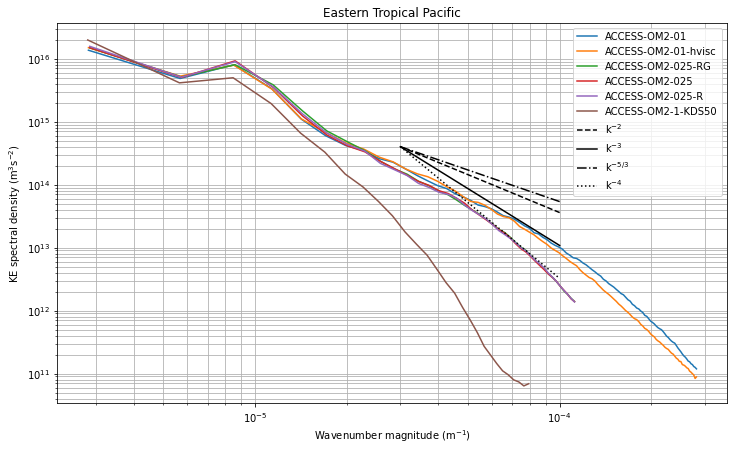

In [32]:
# Plot KE spectra together:            
# for locname,loc in locations.items():
locname='Eastern-Tropical-Pacific'
loc = locations[locname]

fig = plt.figure(figsize=(12,7),facecolor='w')
axs1 = plt.subplot(1,1,1)
cnt=0
for ekey in data.keys():
    col = 'C' + str(cnt)
    cnt = cnt+1
    try:
        kefftradial = data[ekey][locname+'_kefftradial']
        kefftradial.plot(ax=axs1, xscale='log', yscale='log',label=data[ekey]['model'],color=col)
        axs1.set_title(locname.replace('-',' '))
        axs1.set_ylabel('KE spectral density (m$^3$s$^{-2}$)')
        axs1.set_xlabel('Wavenumber magnitude (m$^{-1}$)')
    except:
        print('KE spectra not plotted ' + data[ekey]['model'])

# Add example spectral slopes:
#ks = [3.e0,3.e1]
#E1 = 3.e-3
ks = [3.e-5,1.e-4]
E1 = 4.e14
axs1.plot(ks,[E1*(k/ks[0])**(-2) for k in ks],'--k',label='k$^{-2}$')
axs1.plot(ks,[E1*(k/ks[0])**(-3.) for k in ks],'-k',label='k$^{-3}$')
axs1.plot(ks,[E1*(k/ks[0])**(-5./3.) for k in ks],'-.k',label='k$^{-5/3}$')
axs1.plot(ks,[E1*(k/ks[0])**(-4) for k in ks],':k',label='k$^{-4}$')

# # Add esimated kd:
# kds = kd[locname]
# axs1.plot([kds,kds],[1.e-7,2.e-7],'-r',linewidth=2.)

axs1.grid(which='both', axis='both')
axs1.legend()
#axs1.set_ylim([5.e-8,1.e-2])
#axs1.set_xlim([2.e-1,0.4e2])
#savefigure(locname+'_KE_Spectra_UniformMeters')


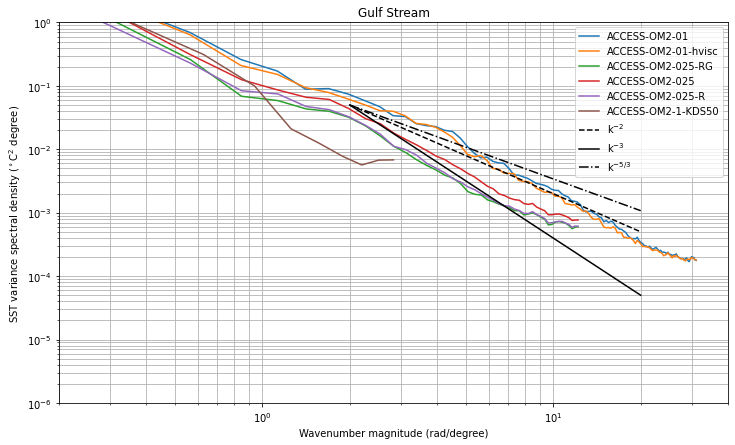

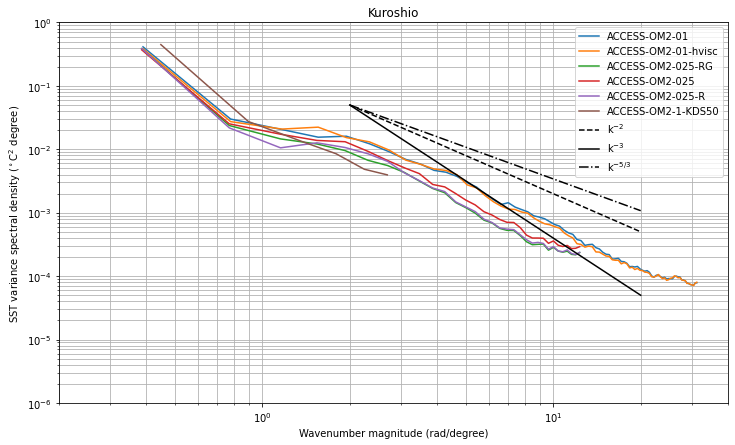

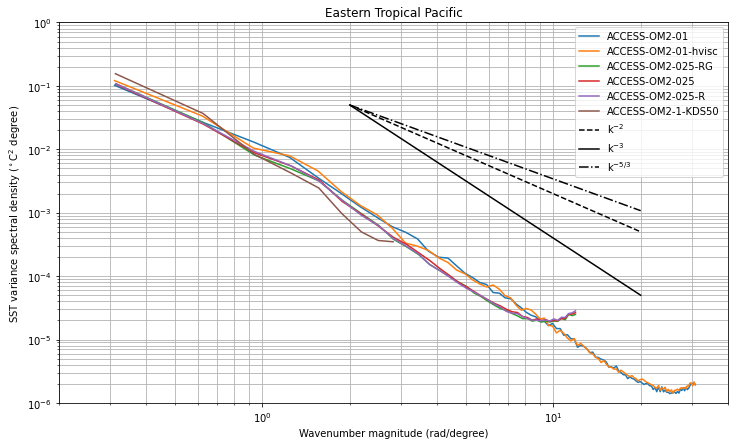

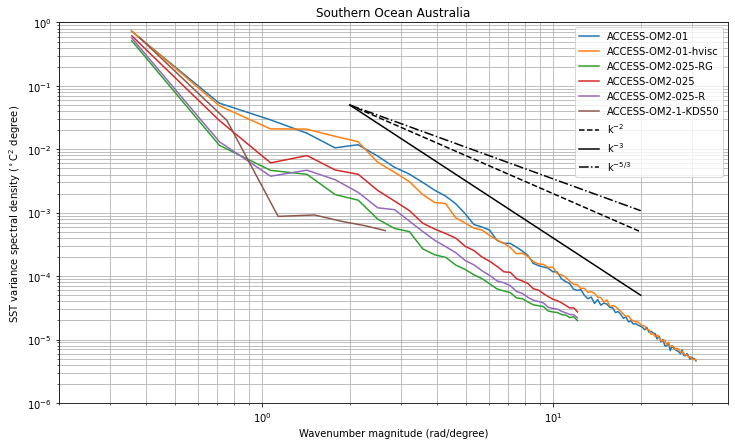

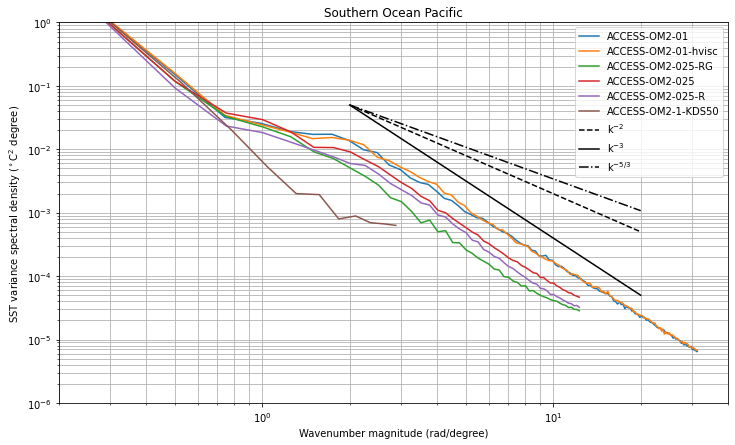

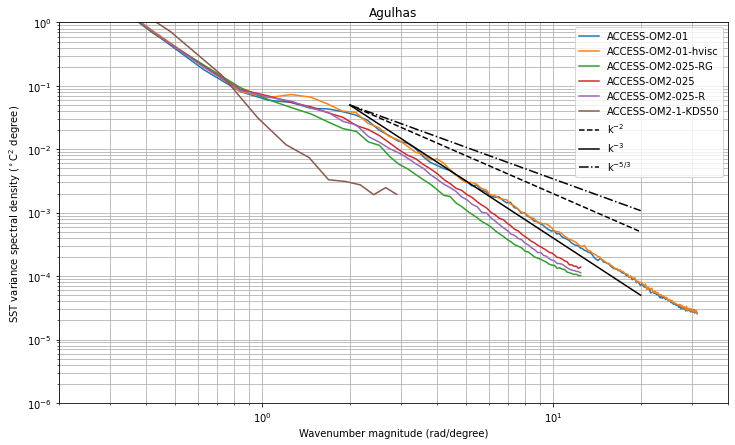

In [68]:
# Plot SST spectra together:            
for locname,loc in locations.items():
    # locname='Agulhas'
    # loc = locations[locname]

    fig3 = plt.figure(figsize=(12,7),facecolor='w')
    axs1 = plt.subplot(1,1,1)
    cnt=0
    for ekey in data.keys():
        col = 'C' + str(cnt)
        cnt = cnt+1
        SSTfftradial = data[ekey][locname+'_SSTfftradial']
        SSTfftradial.plot(ax=axs1, xscale='log', yscale='log',label=data[ekey]['model'],color=col)
        axs1.set_title(locname.replace('-',' '))
        axs1.set_ylabel('SST variance spectral density ($^\circ$C$^2$ degree)')
        axs1.set_xlabel('Wavenumber magnitude (rad/degree)')

    # Add example spectral slopes:
    ks = [2.e0,2.e1]
    E1 = 5.e-2
    axs1.plot(ks,[E1*(k/ks[0])**(-2) for k in ks],'--k',label='k$^{-2}$')
    axs1.plot(ks,[E1*(k/ks[0])**(-3.) for k in ks],'-k',label='k$^{-3}$')
    axs1.plot(ks,[E1*(k/ks[0])**(-5./3.) for k in ks],'-.k',label='k$^{-5/3}$')
#    axs1.plot(ks,[E1*(k/ks[0])**(-4) for k in ks],':k',label='k$^{-4}$')
    axs1.grid(which='both', axis='both')
    axs1.legend()
    axs1.set_ylim([1.e-6,1.e0])
    axs1.set_xlim([2.e-1,0.4e2])
    savefigure(locname+'_SST_Spectra')


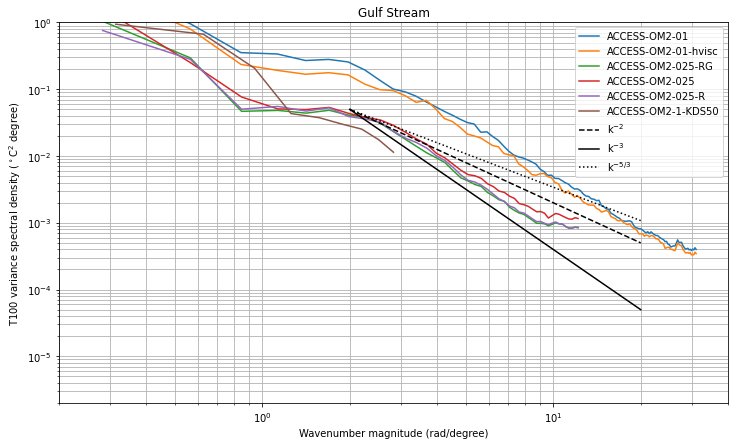

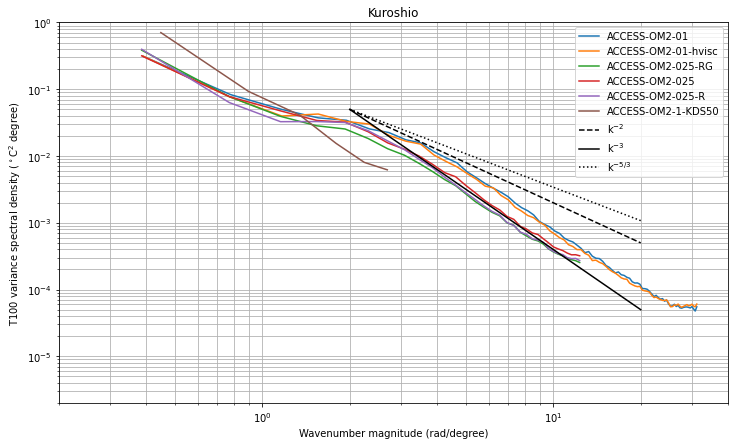

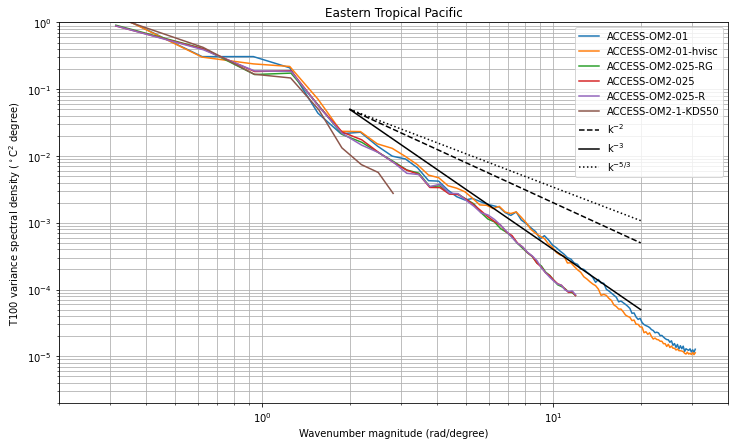

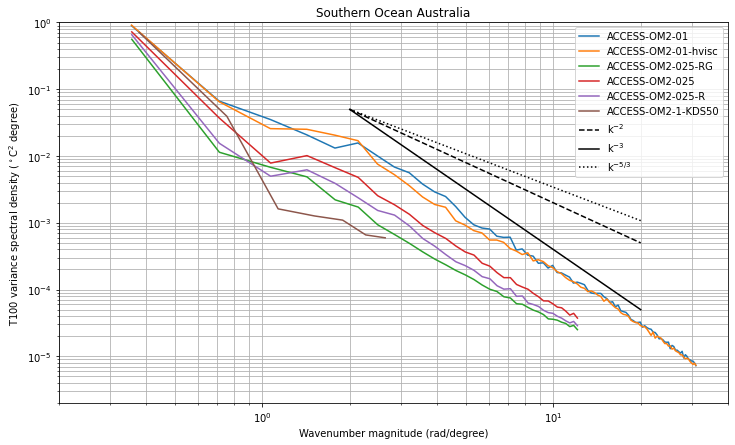

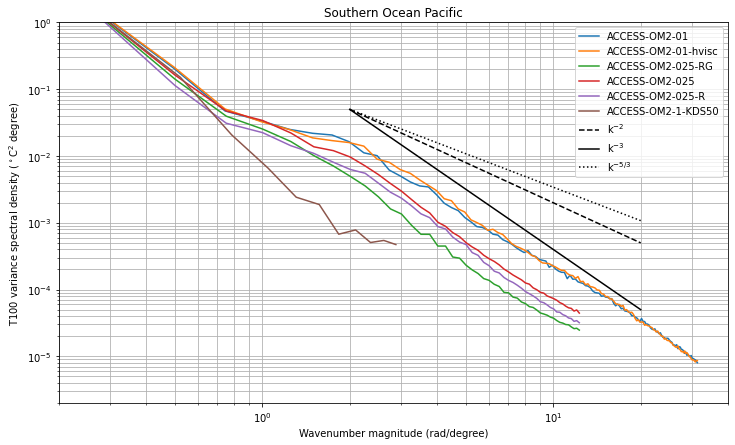

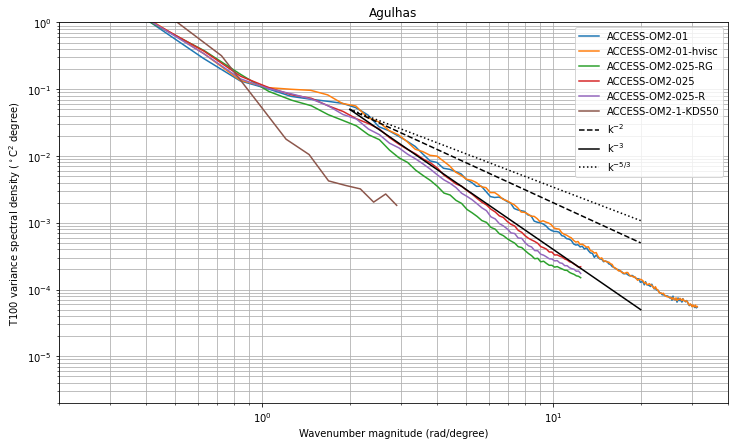

In [67]:
# Plot T100 spectra together:            
for locname,loc in locations.items():
    # locname='Agulhas'
    # loc = locations[locname]

    fig3 = plt.figure(figsize=(12,7),facecolor='w')
    axs1 = plt.subplot(1,1,1)
    cnt=0
    for ekey in data.keys():
        col = 'C' + str(cnt)
        cnt = cnt+1
        T100fftradial = data[ekey][locname+'_T100fftradial']
        T100fftradial.plot(ax=axs1, xscale='log', yscale='log',label=data[ekey]['model'],color=col)
        axs1.set_title(locname.replace('-',' '))
        axs1.set_ylabel('T100 variance spectral density ($^\circ$C$^2$ degree)')
        axs1.set_xlabel('Wavenumber magnitude (rad/degree)')

    # Add example spectral slopes:
    ks = [2.e0,2.e1]
    E1 = 5.e-2
    axs1.plot(ks,[E1*(k/ks[0])**(-2) for k in ks],'--k',label='k$^{-2}$')
    axs1.plot(ks,[E1*(k/ks[0])**(-3.) for k in ks],'-k',label='k$^{-3}$')
    axs1.plot(ks,[E1*(k/ks[0])**(-5./3.) for k in ks],':k',label='k$^{-5/3}$')
    # axs1.plot(ks,[E1*(k/ks[0])**(-4) for k in ks],':k',label='k$^{-4}$')
    axs1.grid(which='both', axis='both')
    axs1.legend()
    axs1.set_ylim([2.e-6,1.e0])
    axs1.set_xlim([2.e-1,0.4e2])
    savefigure(locname+'_T100_Spectra')


# TODO
- Compensate for variance reduction from windowing?
- Compensate for variance reduction from anisotropic high-k cutoff?
- interpolate onto a uniform grid in units of metres (choose a power of 2)
- remove trends from interpolated data - see Errico1985a http://dx.doi.org/10.1175/1520-0493(1985)113<1554:SCFALA>2.0.CO;2
- remove mean (do this with interpolated data so it is area-weighted)


2D fft sum = 2.55e-01
Radial fft sum = 2.12e-01
Spatial sum = 2.59e-01


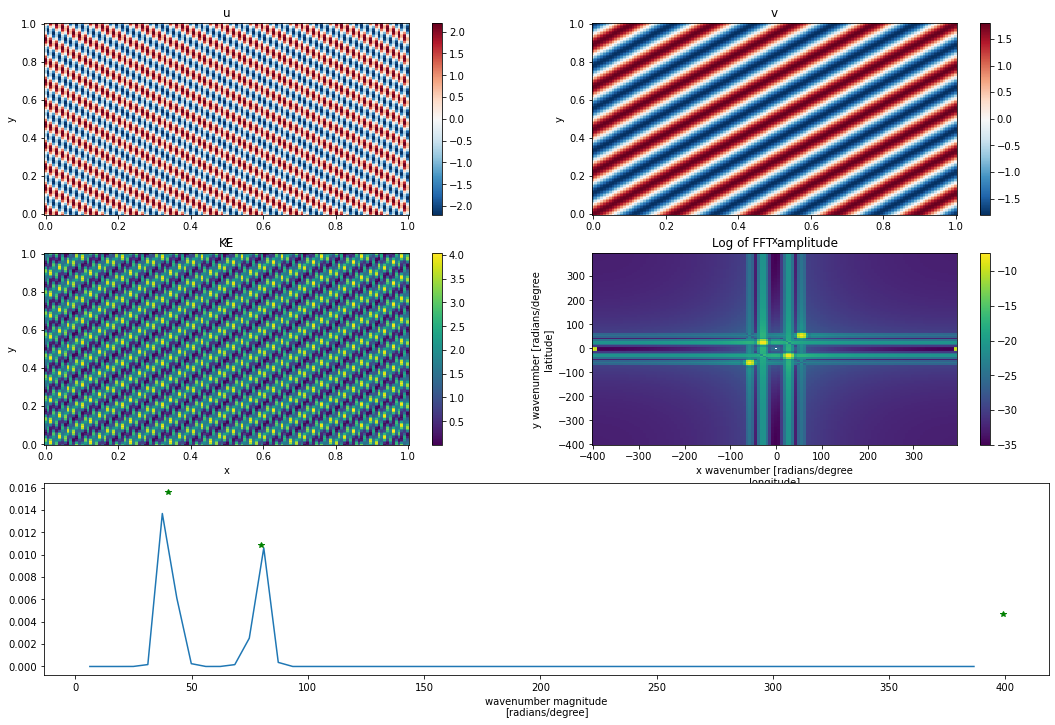

2D fft sum = 2.17e-01
Radial fft sum = 2.15e-01
Spatial sum = 2.20e-01


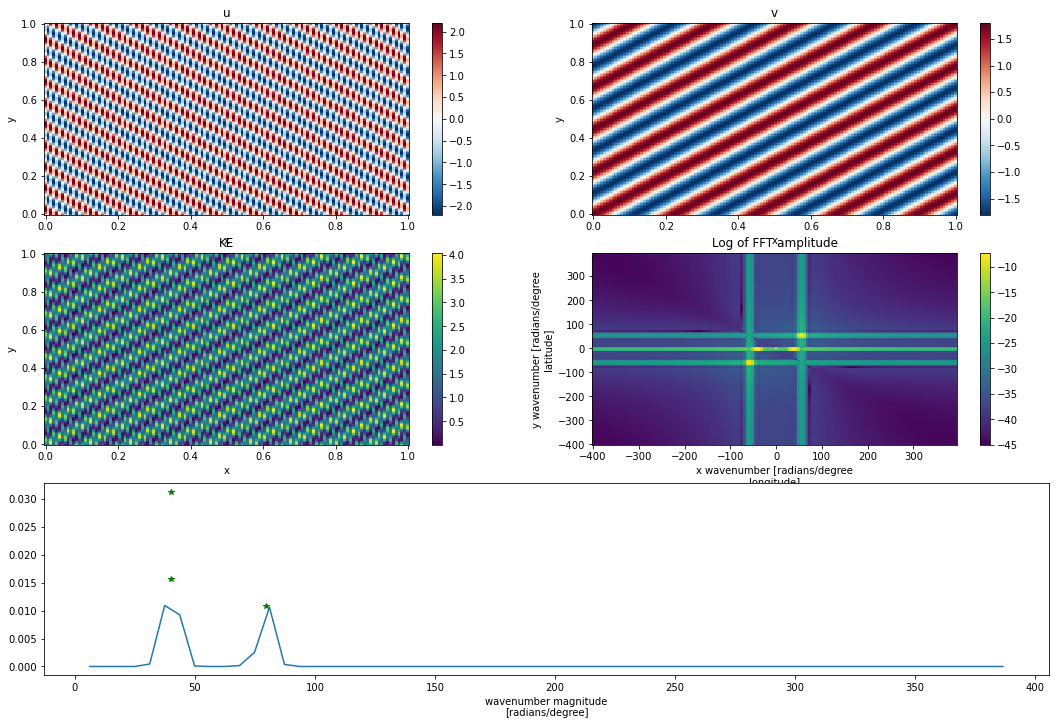

In [22]:
# Testing with dummy data (temperature)

# dimensions
nx, ny = 128, 128
x, y = np.linspace(0.,1.,nx),np.linspace(0.,1.,ny)
dx, dy = np.max(np.diff(x)), np.max(np.diff(y))
X, Y = np.meshgrid(x,y)
t = [0]

# dummy solution
k1, kx = 2.*np.pi/(10.*dx), 2.*np.pi/(20.*dx)
a1, a3 = 1.5, 1.8
T = np.zeros((1,ny,nx))
T[0,:,:] = a1*np.sin(k1*(X+Y)/np.sqrt(2.))+a2*np.cos(kx*X)
T = xr.DataArray(T,coords=[t,y,x],dims=['t','y','x'])

# Calc spectra:
fft = fft_KE(T,0*T)
fftradial = azimuthal_sum(fft)

dki, dkj = np.max(np.diff(fft.ki)), np.max(np.diff(fft.kj))
dkh = np.max(np.diff(fftradial.k))

# check Parseval's theorem
# fft2dsum = fft.sum().sum()*dki*dkj*(2*np.pi/dx)*(2*np.pi/dy) # Extra factors convert k in (cycles/dx) to k in (radians)
# fftrsum = fftradial.sum().sum()*dkh*(2*np.pi/dx)*(2*np.pi/dy) # won't hold exactly if eq (26) applied in azimuthal_sum
fft2dsum = fft.sum().sum()*dki*dkj
fftrsum = fftradial.sum().sum()*dkh
print('2D fft sum = %3.2e' % fft2dsum)
print('Radial fft sum = %3.2e' % fftrsum)

# Spatial sum
Tw = window(window(T,'x'),'y')
Tw -= Tw.mean('x', skipna=True).mean('y', skipna=True)  # remove mean at each time
spsum = (Tw**2./2).sum().sum()*dx*dy/1./1.
print('Spatial sum = %3.2e' % spsum)

fig2 = plt.figure(figsize=(18,12),facecolor='w')
plt.subplot(3,2,1)
u.plot()
plt.title('u')
plt.subplot(3,2,2)
v.plot()
plt.title('v')
plt.subplot(3,2,3)
((u**2.+v**2)/2.).plot()
plt.title('KE')
plt.subplot(3,2,4)
np.log(fft).plot()
plt.title('Log of FFT amplitude')
plt.subplot(3,2,(5,6))
fftradial.plot()

plt.plot([k1],[a1**2*dki*dkj*dx*dy*2],'*g')
plt.plot([k2],[a2**2*dki*dkj*dx*dy*2],'*g')
plt.plot([kx],[2.*a3**2*dki*dkj*dx*dy*2],'*g')